#### Adamantios Zaras AM: 06
#### Panagiotis Souranis AM: 17

# Description
In this part of the project, we created 4 ensemble methods and compared them, using statistical analysis methods in 10 different datasets.
#### Ensembles
1. Bagging Ensemble using Random Tree Classifier.  
We follow the procedure described below:
  - Random Search, in order to search fpr hyperparameters.
  - Grid Search in the area near the best parameters found from the Random Search.
  - 10 fold Cross Validation, in order to plot the accuracy vs the number of classifiers used.
  - Prediction using the best estimation for the number of classifiers, combined with the tuned parameters.
2. Random Forest Classifier.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Prediction using the tuned parameters.
3. Stacking, using a Nearest Neighbors classifier, a Linear SVM, a Decision Tree classifier and a Naive Bayes classifier. The Meta-Classifier is a Logistic Regression Classifier.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Present plots of each model's performane to the dataset and compare them with the stacking model, which combines them all.
  - Prediction using the tuned parameters of each model.  
  
  **Note:** TODO describe how the Stacking Library works. (CV to create meta dataset etc.)

4. Boosting, using XGBoost.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Prediction using the tuned parameters of each model.

#### Datasets
1. [Spambase](https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data)
2. **Wine** - Using sklearn' s import.
3. **Iris** - Using sklearn' s import.
4. [Breast Cancer](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data?fbclid=IwAR2ZT56DdRbU45HMFvq6gwTdjKsS-RLSQ0B1TQM4cskmA27x-upTF0n66BI)
5. [Seeds](https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt)
6. [Glass Identification](https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data)
7. [Tic Tac Toe](https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data)
8. [Wholesale Customers](https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv)
9. **Diabetes** - Using sklearn' s import.
10. [Teaching Assistant Evaluation](https://archive.ics.uci.edu/ml/machine-learning-databases/tae/tae.data)

#### Comparison
TODO describe the comparison procedure.

# Globals


### Import all modules.


In [0]:
import io
import time

import numpy as np
import requests
import seaborn as sns
import xgboost as xgb
from mlxtend.classifier import StackingCVClassifier
from pandas import read_csv
from scipy.stats import randint as sp_randint
from sklearn.datasets import load_wine
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Import util functions.
from utils import report, estimators_vs_acc, plot_accuracy_stacking, plot_learning_curve, full_report

%matplotlib inline


# Spambase



## Prepare the dataset.


In [0]:
# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   39.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

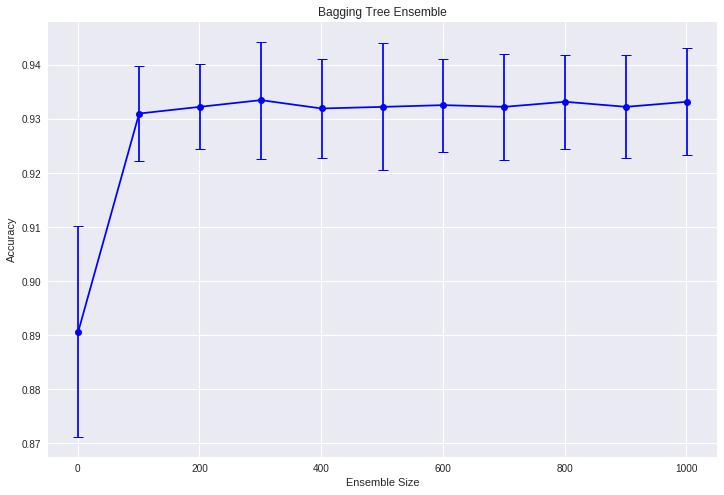

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators for [100, 200, ..., 1000] estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1100, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 800, since the accuracy is high  
and the lower bound of it's deviation is better than the others.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=800, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9210
Precision      0.8864
Recall         0.9229
F1             0.9043


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9232
Precision      0.8870
Recall         0.9283
F1             0.9072


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

Accuracy: 0.85 (+/- 0.03) [KNN]
Accuracy: 0.92 (+/- 0.01) [Linear-SVM]
Accuracy: 0.92 (+/- 0.02) [Decision Tree]
Accuracy: 0.81 (+/- 0.02) [Naive-Bayes]
Accuracy: 0.87 (+/- 0.02) [Logistic Regression]
Accuracy: 0.93 (+/- 0.01) [Stacking]


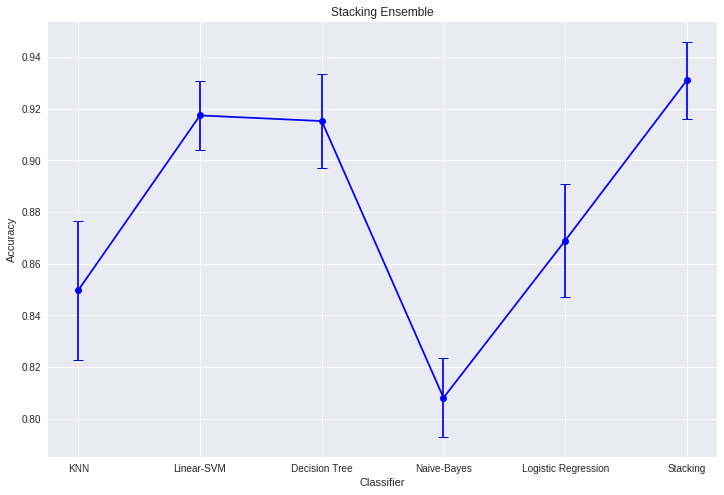

In [75]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

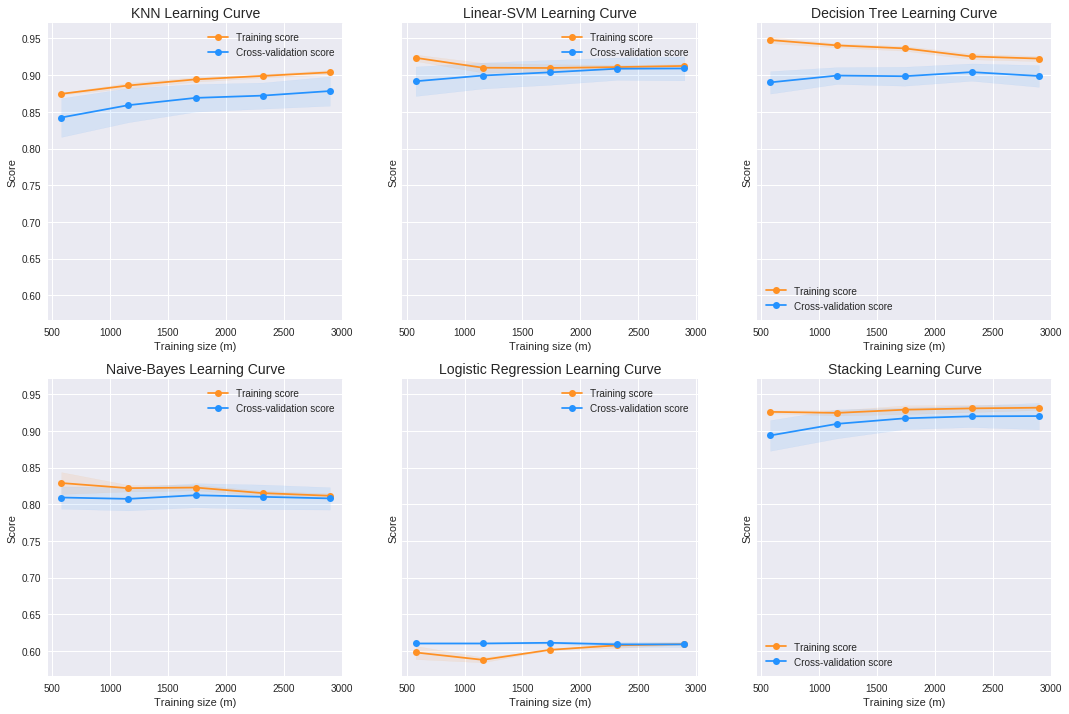

In [72]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [76]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9159
Precision      0.8771
Recall         0.9211
F1             0.8986


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9341
Precision      0.9147
Recall         0.9229
F1             0.9188



# Wine



## Prepare the dataset.


In [0]:
# Get x and y.
X, y = load_wine(True)

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 1000

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 8948 tasks      | elapsed:   11.0s


RandomizedSearchCV took 12.40 seconds for 1000 candidates.
Model with rank: 1
Mean validation score: 0.935 (std: 0.068)
Parameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 4, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.935 (std: 0.048)
Parameters: {'criterion': 'gini', 'max_depth': 36, 'max_features': 6, 'min_samples_split': 32}

Model with rank: 1
Mean validation score: 0.935 (std: 0.058)
Parameters: {'criterion': 'gini', 'max_depth': 36, 'max_features': 2, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.935 (std: 0.058)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 2, 'min_samples_split': 3}



[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   12.1s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(33, 40),
              'max_features': range(2, 7),
              'min_samples_split': range(30, 40),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 700 candidates, totalling 7000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1630 tasks      | elapsed:    1.8s


GridSearchCV took 8.07 seconds.
Model with rank: 1
Mean validation score: 0.935 (std: 0.068)
Parameters: {'criterion': 'gini', 'max_depth': 33, 'max_features': 4, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.935 (std: 0.048)
Parameters: {'criterion': 'gini', 'max_depth': 33, 'max_features': 6, 'min_samples_split': 32}

Model with rank: 1
Mean validation score: 0.935 (std: 0.068)
Parameters: {'criterion': 'gini', 'max_depth': 34, 'max_features': 4, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.935 (std: 0.048)
Parameters: {'criterion': 'gini', 'max_depth': 34, 'max_features': 6, 'min_samples_split': 32}

Model with rank: 1
Mean validation score: 0.935 (std: 0.068)
Parameters: {'criterion': 'gini', 'max_depth': 35, 'max_features': 4, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.935 (std: 0.048)
Parameters: {'criterion': 'gini', 'max_depth': 35, 'max_features': 6, 'min_samples_split': 32}

Model with rank: 1
Mean va

[Parallel(n_jobs=-1)]: Done 7000 out of 7000 | elapsed:    8.0s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

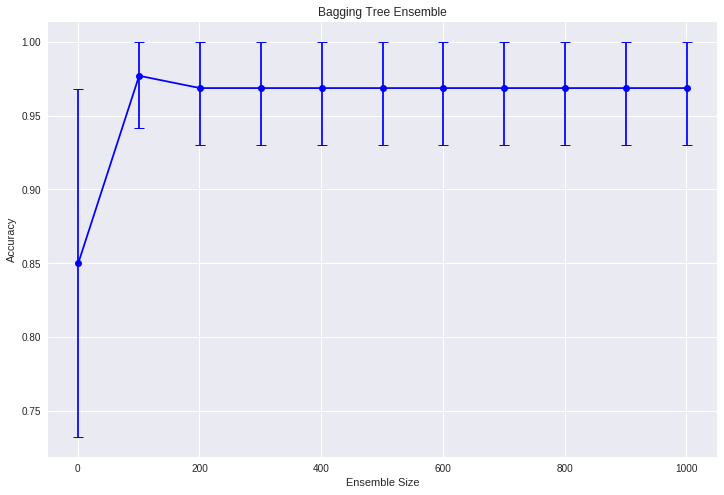

In [0]:

# Add best values for the classifier.
clf.max_depth = 38
clf.max_features = 6
clf.min_samples_split = 32
clf.criterion = 'gini'

# Plot accuracy vs number of estimators for [100, 200, ..., 1000] estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1100, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 100, since the accuracy is high  
and the lower bound of it's deviation is better than the others.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=100, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9074
Precision      0.9131
Recall         0.9171
F1             0.9136


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 379 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 471 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 497 out of 500 | elapsed:  1.0min remaining:    0.4s


RandomizedSearchCV took 63.24 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.978 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 3, 'min_samples_split': 63, 'n_estimators': 58}

Model with rank: 1
Mean validation score: 0.978 (std: 0.027)
Parameters: {'criterion': 'gini', 'max_depth': 34, 'max_features': 3, 'min_samples_split': 37, 'n_estimators': 37}

Model with rank: 3
Mean validation score: 0.972 (std: 0.037)
Parameters: {'criterion': 'gini', 'max_depth': 41, 'max_features': 2, 'min_samples_split': 78, 'n_estimators': 286}

Model with rank: 3
Mean validation score: 0.972 (std: 0.027)
Parameters: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 5, 'min_samples_split': 9, 'n_estimators': 246}

Model with rank: 3
Mean validation score: 0.972 (std: 0.027)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 87}

Model with rank: 3
Mean validation score: 0.972 (std: 

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [5]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(33, 35),
              'max_features': range(2, 4),
              'min_samples_split': range(36, 38),
              'n_estimators': range(30, 40, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    7.0s


GridSearchCV took 10.08 seconds.
Model with rank: 1
Mean validation score: 0.983 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': 33, 'max_features': 2, 'min_samples_split': 37, 'n_estimators': 35}

Model with rank: 1
Mean validation score: 0.983 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': 34, 'max_features': 2, 'min_samples_split': 37, 'n_estimators': 35}

Model with rank: 3
Mean validation score: 0.978 (std: 0.028)
Parameters: {'criterion': 'entropy', 'max_depth': 33, 'max_features': 2, 'min_samples_split': 36, 'n_estimators': 30}

Model with rank: 3
Mean validation score: 0.978 (std: 0.027)
Parameters: {'criterion': 'entropy', 'max_depth': 33, 'max_features': 2, 'min_samples_split': 36, 'n_estimators': 35}

Model with rank: 3
Mean validation score: 0.978 (std: 0.028)
Parameters: {'criterion': 'entropy', 'max_depth': 33, 'max_features': 2, 'min_samples_split': 37, 'n_estimators': 30}

Model with rank: 3
Mean validation score: 0.978 (std: 0.028)
Parame

[Parallel(n_jobs=-1)]: Done 317 out of 320 | elapsed:   10.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   10.0s finished



### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [6]:

# Add best values for the classifier.
clf.max_depth = 33
clf.max_features = 2
clf.min_samples_split = 37
clf.n_estimators = 35
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9630
Precision      0.9610
Recall         0.9673
F1             0.9635


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [46]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 50),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 425 tasks      | elapsed:   11.8s


RandomizedSearchCV took 13.32 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 7, 'kneighborsclassifier__n_neighbors': 9, 'linearsvc__C': 1, 'meta-logisticregression__C': 0.01}

Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 54, 'kneighborsclassifier__n_neighbors': 39, 'linearsvc__C': 1, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 23, 'kneighborsclassifier__n_neighbors': 10, 'linearsvc__C': 1, 'meta-logisticregression__C': 0.1}



[Parallel(n_jobs=-1)]: Done 497 out of 500 | elapsed:   13.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.3s finished


### Grid Search

In [48]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(7, 10),
              'decisiontreeclassifier__max_depth': range(5, 9),
              'meta-logisticregression__C': [0.01, 1]}
clf2.C = 1

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    1.7s


GridSearchCV took 4.62 seconds.
Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 5, 'kneighborsclassifier__n_neighbors': 8, 'meta-logisticregression__C': 0.01}

Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 7, 'kneighborsclassifier__n_neighbors': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 8, 'kneighborsclassifier__n_neighbors': 8, 'meta-logisticregression__C': 0.01}

Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 8, 'kneighborsclassifier__n_neighbors': 9, 'meta-logisticregression__C': 0.01}



[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.6s finished


### Plot stacking results

Accuracy: 0.96 (+/- 0.04) [KNN]
Accuracy: 0.96 (+/- 0.05) [Linear-SVM]
Accuracy: 0.91 (+/- 0.08) [Decision Tree]
Accuracy: 0.98 (+/- 0.05) [Naive-Bayes]
Accuracy: 0.47 (+/- 0.06) [Logistic Regression]
Accuracy: 0.98 (+/- 0.04) [Stacking]


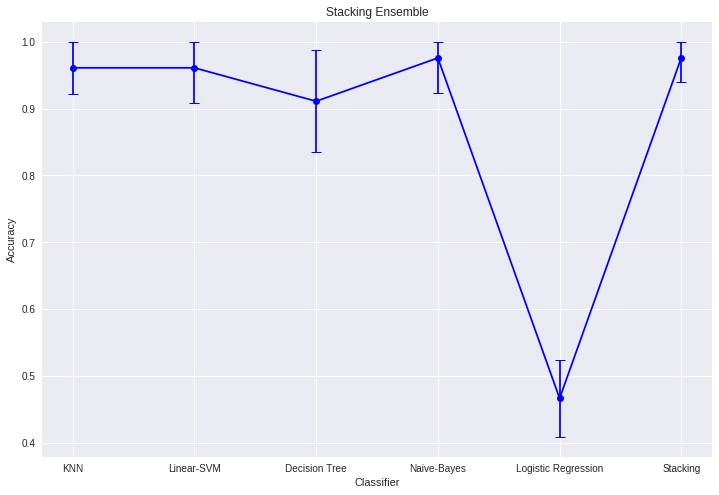

In [52]:
# Use best values for the classifier.
clf1.n_neighbors = 8
clf3.max_depth = 5
meta_clf.C = 0.01

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, we notice that the logistic regression model would not have managed to classify the samples well. However, it is very useful for the classification of the meta-samples. By changing the value of C above to 0.1, it becomes clear, because the model's accuracy to the initial data becomes higher, while the stacking model's accuracy decreases.

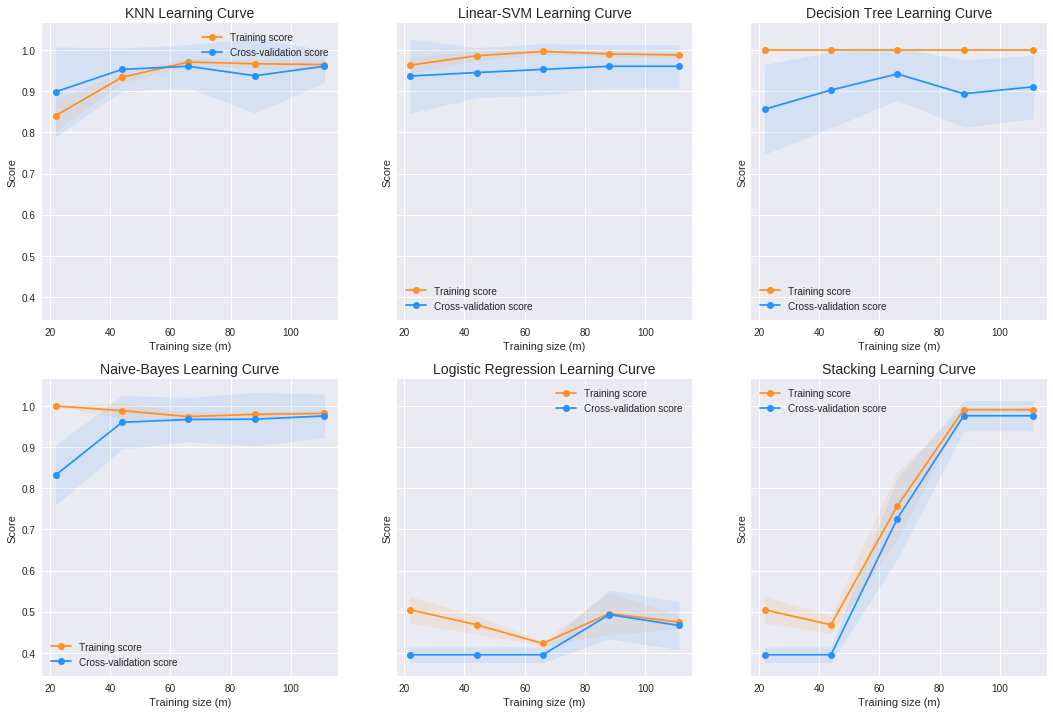

In [69]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [53]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9630
Precision      0.9722
Recall         0.9649
F1             0.9670


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [56]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  3.1min


RandomizedSearchCV took 209.46 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.983 (std: 0.025)
Parameters: {'colsample_bytree': 0.2102738700418474, 'gamma': 1.7839293653154487, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5774151694191269}

Model with rank: 1
Mean validation score: 0.983 (std: 0.025)
Parameters: {'colsample_bytree': 0.13436036736597312, 'gamma': 1.9164900565920913, 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.5774151694191269}

Model with rank: 1
Mean validation score: 0.983 (std: 0.025)
Parameters: {'colsample_bytree': 0.13436036736597312, 'gamma': 1.7839293653154487, 'max_depth': 1, 'min_child_weight': 8, 'subsample': 0.5088198412410906}

Model with rank: 1
Mean validation score: 0.983 (std: 0.025)
Parameters: {'colsample_bytree': 0.2102738700418474, 'gamma': 1.7839293653154487, 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.5774151694191269}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.5min finished


### Grid Search

In [57]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(4, 9),
          'gamma': np.arange(1.7, 1.95, 0.1),
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.57
xgb_clf.colsample_bytree = 0.21

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 105 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  1.2min


GridSearchCV took 88.93 seconds.
Model with rank: 1
Mean validation score: 0.984 (std: 0.031)
Parameters: {'gamma': 1.8, 'max_depth': 3, 'min_child_weight': 6}

Model with rank: 1
Mean validation score: 0.984 (std: 0.031)
Parameters: {'gamma': 1.8, 'max_depth': 4, 'min_child_weight': 6}

Model with rank: 1
Mean validation score: 0.984 (std: 0.031)
Parameters: {'gamma': 1.8, 'max_depth': 5, 'min_child_weight': 6}

Model with rank: 1
Mean validation score: 0.984 (std: 0.031)
Parameters: {'gamma': 1.8, 'max_depth': 6, 'min_child_weight': 6}

Model with rank: 1
Mean validation score: 0.984 (std: 0.031)
Parameters: {'gamma': 1.8, 'max_depth': 7, 'min_child_weight': 6}



[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:  1.5min finished


*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [58]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 8
xgb_clf.gamma = 1.78
xgb_clf.max_depth = 5

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9630
Precision      0.9722
Recall         0.9649
F1             0.9670



# Iris



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

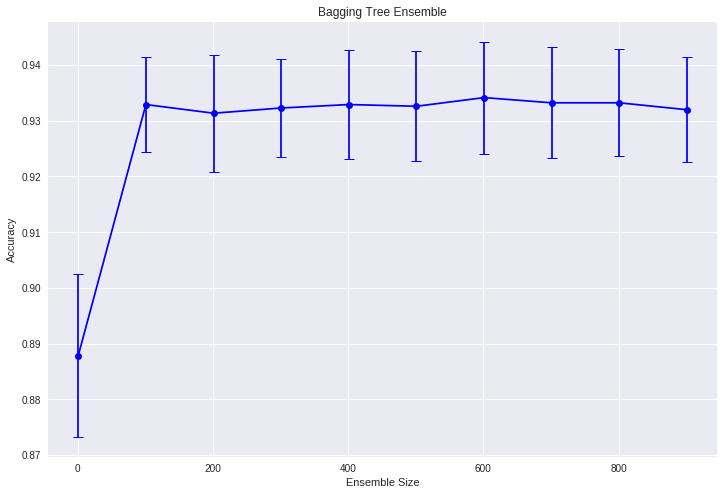

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Breast Cancer


## Prepare the dataset

In [0]:
data = read_csv('C:/Users/User/Desktop/Project Advanced Topics in Ai/datasets/breast-cancer-wisconsin-data/data.csv')
y = data['diagnosis']
unnecessary = ['Unnamed: 32','id','diagnosis']
X = data.drop(unnecessary,axis = 1 )
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Visualize number of data per class

Number of Benign:  357
Number of Malignant :  212


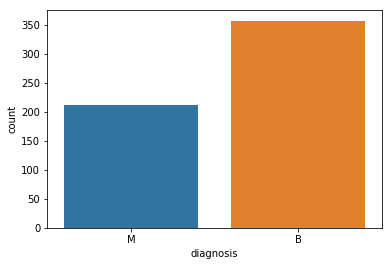

In [0]:
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

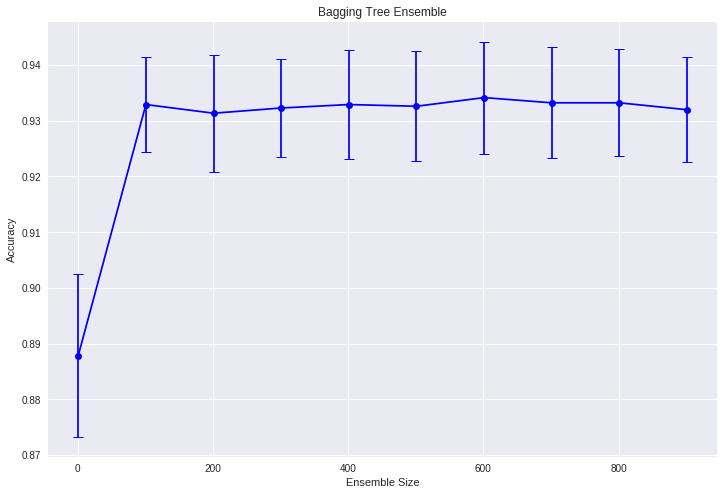

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Seeds



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

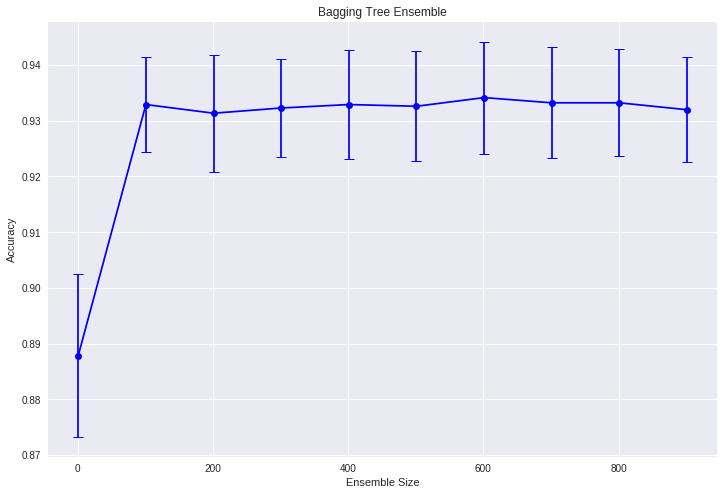

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Glass Identification



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

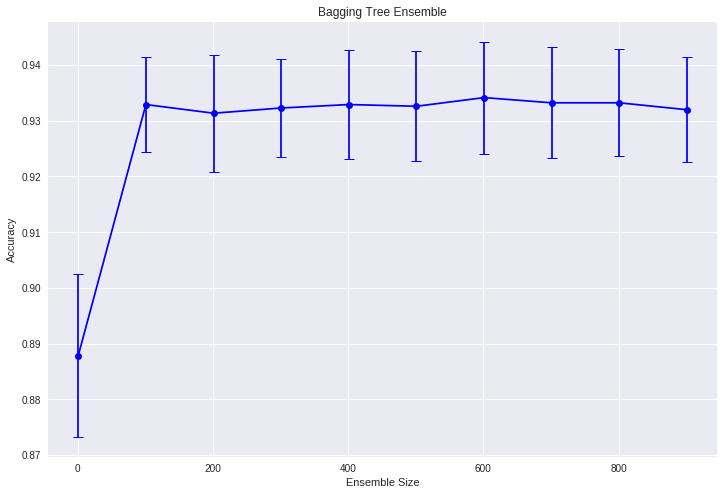

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Tic Tac Toe



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

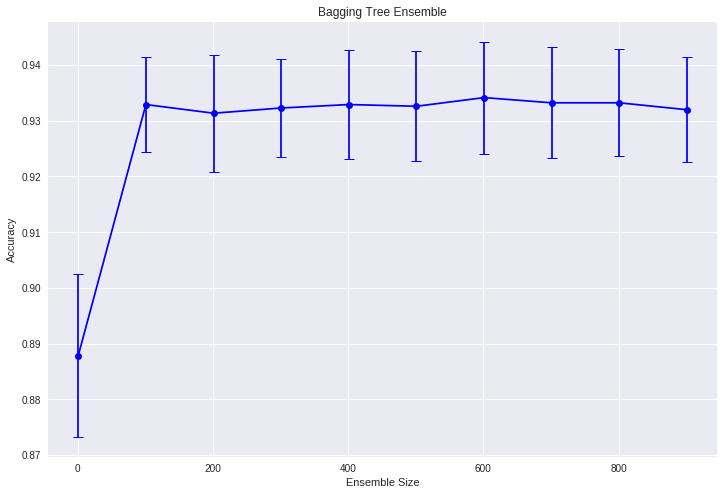

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Wholesale Customers



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

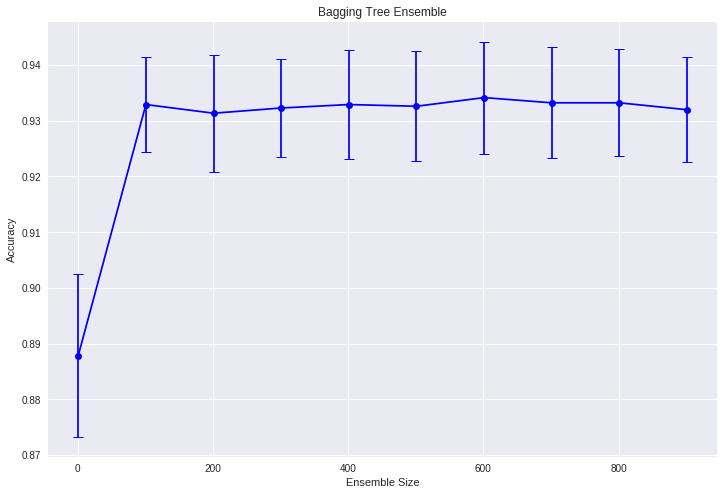

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Diabetes



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

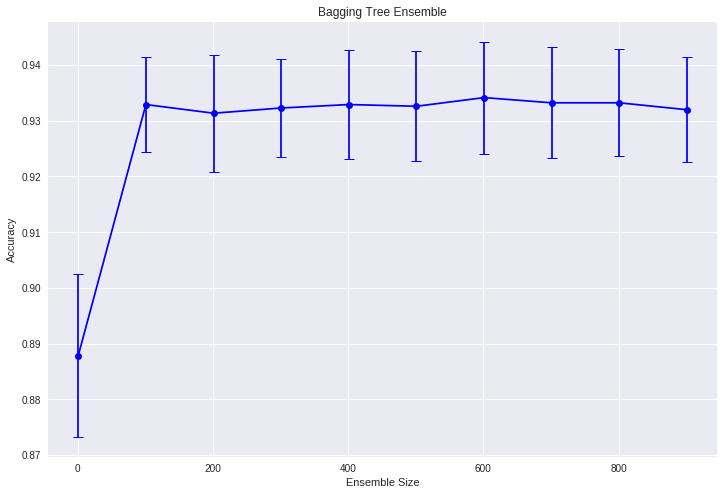

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Teaching Assistant Evaluation



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

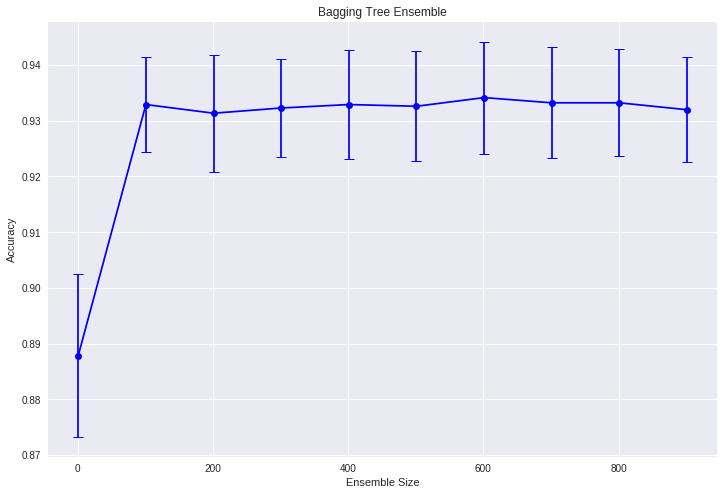

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331


# Results
TODO Statistical tests

# Conclusion

TODO